# Training a model to identify different sports

In this notebook, we aim to build a deep learning model which will classify images according to what sport is being played in them. We have 8 different types of sports - Badminton, Bocce, Croquet, Polo, Rock Climbing, Rowing, Sailing, and Snowboarding.

We will build two models-  
1. **CNN with the basic architecture** - Conv2D layers, Max Pooling Layers, followed by Dense Layers.
2. **CNN with Transfer Learning** - Weights from a pre-trained model, followed by a Dense Layer for our problem.

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Image & Batch Size

We will resize all images to 224 x 224, and our batch size will be 32.

In [2]:
IMAGE_LEN = 224
IMAGE_SIZE = (IMAGE_LEN, IMAGE_LEN)
BATCH_SIZE = 32

### Dataset Information

The dataset contains 1579 images, which will be split into training and validaiton sets. 80% of the images will be used to train the model, and the other 20% will be used for validation.

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/sshre/Downloads/Sports Classifier/sport_dataset",
    validation_split=0.2,
    subset="training",
    label_mode = "categorical",
    seed=1005,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/sshre/Downloads/Sports Classifier/sport_dataset",
    validation_split=0.2,
    subset="validation",
    label_mode = "categorical",
    seed=1005,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

#store class names
class_names = train_ds.class_names

Found 1579 files belonging to 8 classes.
Using 1264 files for training.
Found 1579 files belonging to 8 classes.
Using 315 files for validation.


In [4]:
#prefetch data to speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Visualize Training Data

Let us take a look at some of our training data.

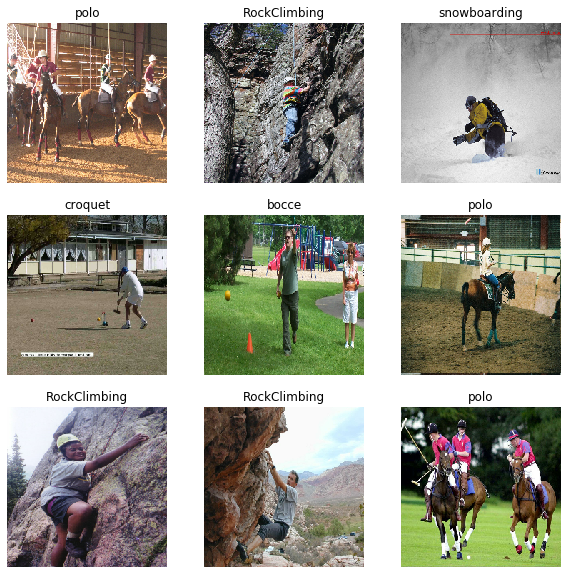

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

## Approach 1 - Basic CNN

The first two layers we are using are responsible for rescaling and data augmentation. Within the data augmentation layer, we are using a horizontal flip and a random zoom. The augmentation ensures that the training data is reshaped and re-fed into the model, thus increasing the number of examples our model is learning on. Ultimately, this helps the model generalize better.  

For the learning itself, our model has 3 Convolution layers, each followed by a Max Pool layer. After 3 sets of convolution layers, we incorporate a dropout layer, a dense layer with 128 neurons, and finally a dense layer with 8 neurons - which correspond to the 8 sports that we want to predict. Kindly note that we will be using the **relu** activation throughout.

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomZoom(0.10),
    ]
)

num_classes = 8

model = Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### Optimization,  Learning Parameters, Loss & Metrics

**Optimizer**: We will be using the basic stochastic gradient descent (SGD) optimizer with a learning rate of 0.005 and a momentum of 0.9.  
**Loss**: We will use Categorical Crossentropy, which means that our response is coded into one-hot vectors.  
**Metrics**: While we will be monitoring loss, we want to take a look at accuracy as well.

In [7]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

### Fitting the Model

We have around 6.4 million parameters to train, so it might be a little slow. Let us start off with 20 epochs to get a feel for how well our model is learning.

In [9]:
epochs = 20

trialOne = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/20
40/40 [==============================] - 40s 998ms/step - loss: 2.0166 - accuracy: 0.2057 - val_loss: 1.7928 - val_accuracy: 0.4730
Epoch 2/20
40/40 [==============================] - 31s 764ms/step - loss: 1.7684 - accuracy: 0.3584 - val_loss: 1.6691 - val_accuracy: 0.4349
Epoch 3/20
40/40 [==============================] - 30s 759ms/step - loss: 1.5646 - accuracy: 0.4929 - val_loss: 1.4250 - val_accuracy: 0.5175
Epoch 4/20
40/40 [==============================] - 29s 727ms/step - loss: 1.4066 - accuracy: 0.5672 - val_loss: 1.2453 - val_accuracy: 0.6540
Epoch 5/20
40/40 [==============================] - 30s 753ms/step - loss: 1.3194 - accuracy: 0.6242 - val_loss: 1.2466 - val_accuracy: 0.6444
Epoch 6/20
40/40 [==============================] - 30s 748ms/step - loss: 1.2811 - accuracy: 0.6677 - val_loss: 1.2899 - val_accuracy: 0.6571
Epoch 7/20
40/40 [==============================] - 30s 750ms/step - loss: 1.2371 - accuracy: 0.6653 - val_loss: 1.1819 - val_accuracy: 0.6952

### Visualize Loss Plots

Visualizing the loss vs. iterations plots tells us if our model is overfitting or not, and gives us an overall idea of how fast the model is learning.

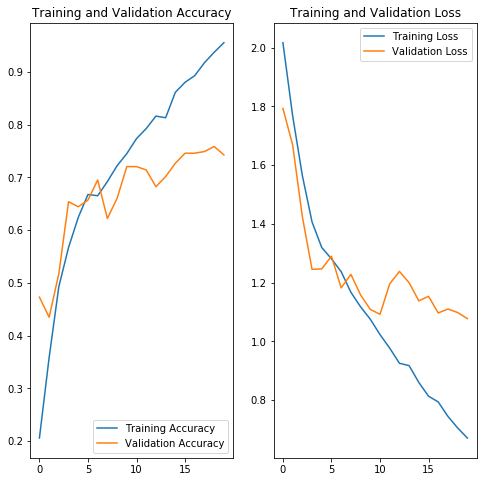

In [11]:
acc = trialOne.history['accuracy']
val_acc = trialOne.history['val_accuracy']

loss = trialOne.history['loss']
val_loss = trialOne.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion for Approach 1

Form the plots above, we see that validation accuracy and loss have started to plateau around iteration 10. The training loss continued to decline all the way to iteration 20, which means our model is able to learn but is not able to generalize well.

After 20 epochs:

**Training Loss** : 0.6710  
**Training Accuracy** : 0.9557  

**Validation Loss** : 1.0774  
**Validation Accuracy** : 0.7429  

## Approach 2 - Transfer Learning

Once again, the first two layers we are using are responsible for rescaling and data augmentation. We are using the same data augmentation process as last time.  

For the learning, our model first reads the pre-trained weights, after which we have a dropout layer, followed by a dense layer with 8 neurons - which correspond to the 8 sports that we want to predict. This time, we expect the number of trainable parameters to be much lesser than in Approach 1.  

Even though the model below looks simple, we must keep in mind that the pre-trained weights bring in a lot of "experience" when it comes to the task at hand. We hypothesize that this model will outperform the Basic CNN model (Approach 1).

In [12]:
module_selection = ("mobilenet_v2_100_224", IMAGE_LEN) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [13]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomZoom(0.10),
    ]
)

num_classes = 8
do_fine_tuning = False

model = Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    layers.Dropout(0.2),
    layers.Dense(num_classes)
])

### Optimization,  Learning Parameters, Loss & Metrics

**Optimizer**: We will be using the basic stochastic gradient descent (SGD) optimizer with a learning rate of 0.005 and a momentum of 0.9.  
**Loss**: We will use Categorical Crossentropy, which means that our response is coded into one-hot vectors.  
**Metrics**: While we will be monitoring loss, we want to take a look at accuracy as well.

In [14]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 10248     
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


### Fitting the Model

This time, we have around 2.2 million parameters in the model, but since we are using pre-trained weights, only about 10,000 of them are trainable. We might not need as many epochs as we did earlier, so let us start with 5 epochs to gauge how well our model learns.

In [16]:
epochs = 5

trialTwo = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/5
40/40 [==============================] - 25s 630ms/step - loss: 1.1769 - accuracy: 0.7255 - val_loss: 0.6754 - val_accuracy: 0.9619
Epoch 2/5
40/40 [==============================] - 30s 738ms/step - loss: 0.7030 - accuracy: 0.9399 - val_loss: 0.6088 - val_accuracy: 0.9778
Epoch 3/5
40/40 [==============================] - 27s 677ms/step - loss: 0.6451 - accuracy: 0.9573 - val_loss: 0.6029 - val_accuracy: 0.9651
Epoch 4/5
40/40 [==============================] - 28s 702ms/step - loss: 0.6298 - accuracy: 0.9604 - val_loss: 0.5858 - val_accuracy: 0.9810
Epoch 5/5
40/40 [==============================] - 29s 733ms/step - loss: 0.6248 - accuracy: 0.9604 - val_loss: 0.5827 - val_accuracy: 0.9746


### Visualize Loss Plots

Visualizing the loss vs. iterations plots tells us if our model is overfitting or not, and gives us an overall idea of how fast the model is learning.

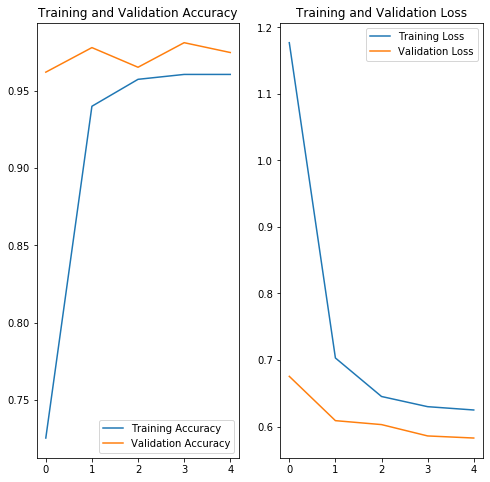

In [17]:
acc = trialTwo.history['accuracy']
val_acc = trialTwo.history['val_accuracy']

loss = trialTwo.history['loss']
val_loss = trialTwo.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion for Approach 2

After just 5 epochs, the validation loss is extremely low, and the validation accuracy is extremely high. The "experience" that the pre-trained weights have brought has made our model much more robust and accurate.  

After 5 epochs:

**Training Loss** : 0.6248  
**Training Accuracy** : 0.9604  

**Validation Loss** : 0.5827  
**Validation Accuracy** : 0.9746  

## Predicting on Test Data

Finally, let us use our transfer learning model to test on completely new data. The model has not seem this data before. The test dataset contains 16 images - 2 from each sport. We will look at every single one of them along with their predictions.

In [30]:
testSet = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/sshre/Downloads/Sports Classifier/testSet",
    shuffle=True,
    label_mode = "categorical",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 16 files belonging to 8 classes.


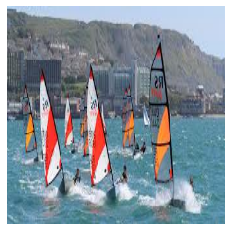

True label: sailing
Predicted label: sailing


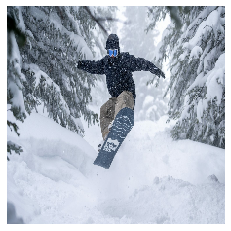

True label: snowboarding
Predicted label: snowboarding


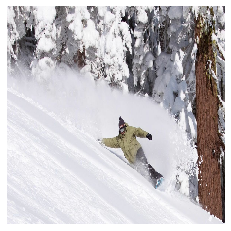

True label: snowboarding
Predicted label: snowboarding


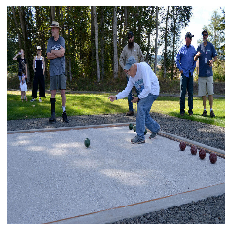

True label: bocce
Predicted label: bocce


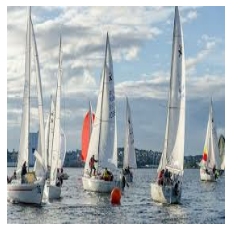

True label: sailing
Predicted label: sailing


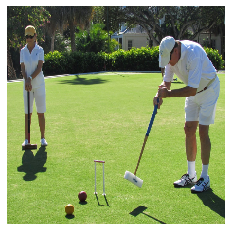

True label: croquet
Predicted label: croquet


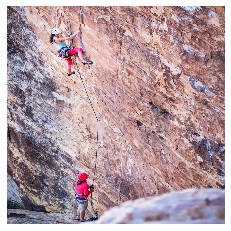

True label: RockClimbing
Predicted label: RockClimbing


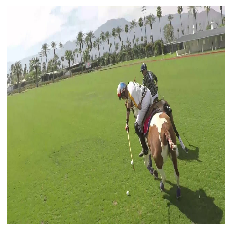

True label: polo
Predicted label: polo


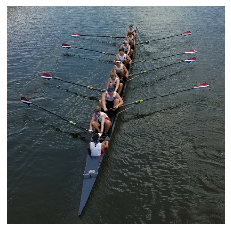

True label: rowing
Predicted label: rowing


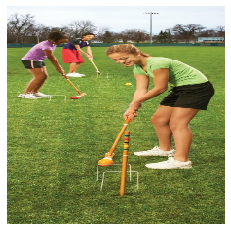

True label: croquet
Predicted label: croquet


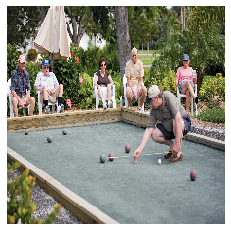

True label: bocce
Predicted label: bocce


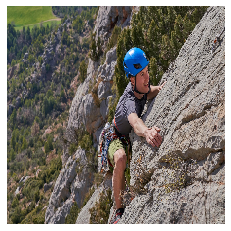

True label: RockClimbing
Predicted label: RockClimbing


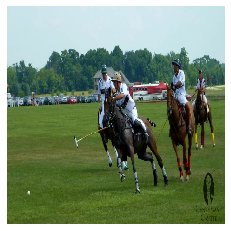

True label: polo
Predicted label: polo


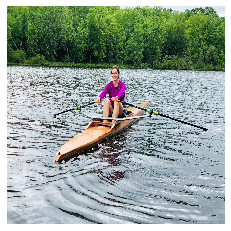

True label: rowing
Predicted label: rowing


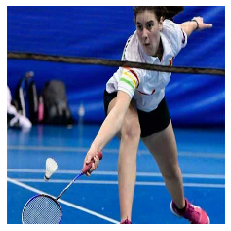

True label: badminton
Predicted label: badminton


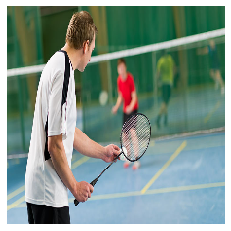

True label: badminton
Predicted label: badminton


In [38]:
def get_class_string_from_index(index):
    return testSet.class_names[index]
        
for images, labels in testSet.take(1):
    for i in range(16):
        plt.imshow(images[i].numpy().astype("uint8"))
        true_index = np.argmax(labels[i])
        plt.axis("off")
        plt.show()
        
        prediction_scores = model.predict(np.expand_dims(images[i], axis=0))
        predicted_index = np.argmax(prediction_scores)
        print("True label: " + get_class_string_from_index(true_index))
        print("Predicted label: " + get_class_string_from_index(predicted_index))

Our model predicted every single one of them correctly!